# Kredi Kartı Verileri – SOM ile Kümeleme
Bu not defterinde, [Kaggle’daki ccdata veri seti](https://www.kaggle.com/arjunbhasin2013/ccdata) (kredi kartı müşterileri) üzerinde **SOM** tabanlı kümeleme yapılmaktadır.

## Adımlar
1. Kütüphaneleri yükle
2. `ccdata.csv` dosyasını oku
3. Gerekli sütunları seç veya ön işleme yap
4. SOM ağı (20×20) oluştur ve eğit
5. 2 boyutlu projeksiyon + K-Means ile kümeler
6. Sonuç analizi


In [1]:
# 1) Kütüphanelerin yüklenmesi
# !pip install SimpSOM
# !pip install pandas numpy scikit-learn

import pandas as pd
import simpsom as sps
from sklearn.cluster import KMeans
import numpy as np

print("Kütüphaneler yüklendi.")

Kütüphaneler yüklendi.


## 2) Veri Setinin Okunması
[Kaggle kaynağından](https://www.kaggle.com/arjunbhasin2013/ccdata) indirilen `CC GENERAL.csv` veya benzeri isimde olabilir. Dosyayı indirip, adını `ccdata.csv` şeklinde değiştirebilir ve `.ipynb` ile aynı klasöre koyabilirsiniz.

Veri setinde tipik olarak:
- CUST_ID
- BALANCE
- PURCHASES
- ...
gibi birçok sayısal sütun bulunur.

Bu örnekte basit olması açısından birkaç sütun seçeceğiz. (İsteyen herkes veriyi temizleyip daha kapsamlı işlem yapabilir.)

In [3]:
df = pd.read_csv("ccdata.csv")  # Dosya adı, size göre fark edebilir
print("Veri boyutu:", df.shape)
df.head()

Veri boyutu: (8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## 3) Veri Temizleme ve Sütun Seçme
Kredi kartı veri setinde boş değerler (NaN) bulunabilir. Bazı sütunları `dropna()` gibi fonksiyonlarla temizleyebilirsiniz. Ayrıca `CUST_ID` gibi metinsel kimlik sütunlarını modelden çıkarıyoruz.

Örnek olarak birkaç sayısal sütunu alalım: `BALANCE`, `PURCHASES`, `CASH_ADVANCE`, `CREDIT_LIMIT`, `PAYMENTS` vb.

In [4]:
# Boş değerleri doldurma veya çıkarma
df.dropna(inplace=True)

df2 = df.drop(columns=["CUST_ID"], errors='ignore')  # Müşteri ID'yi çıkar
sütunlar = ["BALANCE", "PURCHASES", "CASH_ADVANCE", "CREDIT_LIMIT", "PAYMENTS"]

# Var olan sütunları alalım
df2 = df2[sütunlar]

print("Seçilen sütunlar:", df2.columns.tolist())
df2.head()

Seçilen sütunlar: ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']


,BALANCE,PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS
0,40.900749,95.40,0.000000,1000.0,201.802084
1,3202.467416,0.00,6442.945483,7000.0,4103.032597
2,2495.148862,773.17,0.000000,7500.0,622.066742
4,817.714335,16.00,0.000000,1200.0,678.334763
5,1809.828751,1333.28,0.000000,1800.0,1400.057770


## 4) SOM Ağı Oluşturma ve Eğitme
Yine 20×20 bir ağ oluşturuyoruz. 0.01 öğrenme katsayısı ve 2000 epok (istediğiniz gibi değiştirebilirsiniz).

In [6]:
X = df2.values

net = sps.SOMNet(
    20, 20,  # harita boyutu
    X,       # NumPy array verisi
    PBC=True
)
print("SOM oluşturuldu.")

# Ağı eğitelim (2000 epok, öğrenme katsayısı 0.01)
net.train(train_algo='batch', epochs=2000, start_learning_rate=0.01)
print("SOM eğitimi tamamlandı.")

Periodic Boundary Conditions active.
The weights will be initialized with PCA.
SOM oluşturuldu.
The map will be trained with the batch algorithm.
Training SOM... done!
SOM eğitimi tamamlandı.


## 5) 2D Projeksiyon ve K-Means ile Kümeleme
Bu aşamada `net.project(X)` ile 2 boyutlu koordinatlar elde eder, `KMeans` (örneğin 3 kümeye) uygularız.

In [7]:
coords = np.array(net.project(X))
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(coords)

print("Küme etiketleri (ilk 20):", labels[:20])
print("Toplam örnek sayısı:", len(labels))

/Users/atakanemre/.pyenv/versions/3.11.0/lib/python3.11/site-packages/simpsom/network.py:629: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter([pos[0]-0.125+random.random()*0.25 for pos in bmu_list],


Küme etiketleri (ilk 20): [1 2 0 1 1 2 1 0 0 1 0 1 0 1 2 2 0 0 2 1]
Toplam örnek sayısı: 8636


<Figure size 640x480 with 0 Axes>

## 6) Sonuç Analizi
DataFrame’e `Cluster` sütunu ekleyerek hangi müşterinin (satırın) hangi kümeye denk geldiğini inceleyebiliriz.

In [8]:
df2["Cluster"] = labels
df2.head(10)

,BALANCE,PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,Cluster
0,40.900749,95.40,0.000000,1000.0,201.802084,1
1,3202.467416,0.00,6442.945483,7000.0,4103.032597,2
2,2495.148862,773.17,0.000000,7500.0,622.066742,0
4,817.714335,16.00,0.000000,1200.0,678.334763,1
5,1809.828751,1333.28,0.000000,1800.0,1400.057770,1
6,627.260806,7091.01,0.000000,13500.0,6354.314328,2
7,1823.652743,436.20,0.000000,2300.0,679.065082,1
8,1014.926473,861.49,0.000000,7000.0,688.278568,0
9,152.225975,1281.60,0.000000,11000.0,1164.770591,0
10,1293.124939,920.12,0.000000,1200.0,1083.301007,1


/Users/atakanemre/.pyenv/versions/3.11.0/lib/python3.11/site-packages/simpsom/network.py:629: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter([pos[0]-0.125+random.random()*0.25 for pos in bmu_list],


<Figure size 640x480 with 0 Axes>

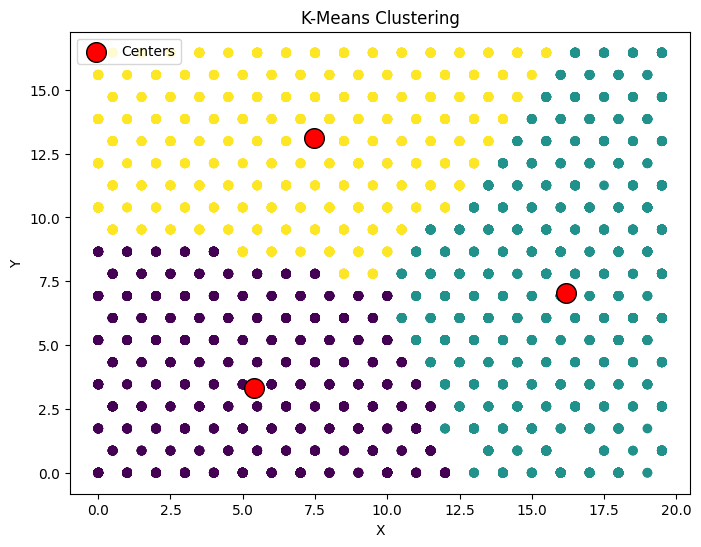

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# net.project(X) -> 2 boyutlu koordinatların listesi 
map_coords = np.array(net.project(X))  # X.values yerine X kullanıyoruz
labels = kmeans.labels_
centers = kmeans.cluster_centers_

plt.figure(figsize=(8,6))
plt.scatter(
    map_coords[:, 0], 
    map_coords[:, 1], 
    c=labels, 
    cmap='viridis'
)
plt.scatter(
    centers[:, 0], 
    centers[:, 1],
    marker='o', 
    s=200, 
    c='red', 
    edgecolor='k', 
    label='Centers'
)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('K-Means Clustering')
plt.legend()
plt.show()

Böylece her müşteri (kredi kartı kullanıcısı), 3 kümeden birine atanmış oldu. Kümelerin hangi özelliklerde ayrıştığını inceleyip, "Yüksek Harcama grubu" vs. gibi yorumlar yapılabilir.

